# 05. Lesion Segmentation (U-Net) with Real/Hybrid Data

This notebook implements Lesion Segmentation using U-Net.
It employs a **Hybrid Data Strategy** to avoid large downloads:
1. **Real Backgrounds**: Uses real healthy brain scans from your existing dataset.
2. **Synthetic Lesions**: Injects realistic-looking lesions (hemorrhage/tumors) into these scans.
3. **Automatic Masks**: Generates perfect ground truth masks for the injected lesions.

This allows you to train a functional segmentation model on "Real-looking" data without needing 50GB+ of manually labeled masks.

In [1]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Try importing nibabel for NIfTI support (optional future proofing)
try:
    import nibabel as nib
    HAS_NIBABEL = True
except ImportError:
    HAS_NIBABEL = False

# Config
IMG_SIZE = 224
BATCH_SIZE = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: mps


## 1. Data Selection

In [2]:
DATA_ROOT = '../Data'
REAL_SEG_PATHS = {
    'hemorrhage': os.path.join(DATA_ROOT, 'PhysioNet_CT_ICH'),
    'ischemia': os.path.join(DATA_ROOT, 'ISLES2022'),
    'tumor': os.path.join(DATA_ROOT, 'BraTS')
}

FOUND_REAL_NIFTI = False
TARGET_PATH = None

if HAS_NIBABEL:
    for dtype, path in REAL_SEG_PATHS.items():
        if os.path.exists(path) and len(glob.glob(os.path.join(path, '**', '*.nii*'), recursive=True)) > 0:
            print(f"Found REAL NIfTI dataset for {dtype} at {path}")
            TARGET_PATH = path
            FOUND_REAL_NIFTI = True
            break

## 2. Hybrid Data Generator (Realistic Fallback)
If no external segmentation dataset is present, we inject synthetic lesions into real "Normal" brain scans.
This avoids large downloads while providing realistic training data.

In [3]:
class HybridLesionDataset(Dataset):
    def __init__(self, background_dir, img_size=224, num_samples=300):
        self.img_size = img_size
        self.num_samples = num_samples
        # Look for Normal images to use as background
        self.bg_files = glob.glob(os.path.join(background_dir, '**', '*.png'), recursive=True)
        if not self.bg_files:
            # Fallback for folder structure variation
            self.bg_files = glob.glob(os.path.join(background_dir, '*.png'))
        
        print(f"Hybrid Generator: Found {len(self.bg_files)} background images to use.")
        
    def _create_random_lesion_mask(self, shape):
        mask = np.zeros((shape[0], shape[1]), dtype=np.float32)
        
        # Random lesion parameters
        center_x = np.random.randint(50, shape[1] - 50)
        center_y = np.random.randint(50, shape[0] - 50)
        axes_x = np.random.randint(10, 35)
        axes_y = np.random.randint(10, 35)
        angle = np.random.randint(0, 360)
        
        # Draw irregular ellipse
        cv2.ellipse(mask, (center_x, center_y), (axes_x, axes_y), angle, 0, 360, 1.0, -1)
        
        # Add some irregularity/noise to the shape
        kernel_size = np.random.randint(3, 7)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        if np.random.rand() > 0.5:
            mask = cv2.dilate(mask, kernel, iterations=1)
        else:
            mask = cv2.erode(mask, kernel, iterations=1)
            
        return mask

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # 1. Load random real background
        if self.bg_files:
            bg_path = random.choice(self.bg_files)
            img = cv2.imread(bg_path)
            if img is None: 
                img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            else:
                img = cv2.resize(img, (self.img_size, self.img_size))
                # Ensure RGB
                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)

        # 2. Generate Lesion Mask
        mask_np = self._create_random_lesion_mask(img.shape)
        
        # 3. Inject Lesion (Simulate Hyperdense Hemorrhage)
        img_float = img.astype(np.float32)
        
        # Blur mask for blending
        mask_blurred = cv2.GaussianBlur(mask_np, (5, 5), 0)
        mask_3ch = np.stack([mask_blurred]*3, axis=2)
        
        # Additive blending: Brighten the lesion area
        blended = img_float + (mask_3ch * 80.0)
        blended = np.clip(blended, 0, 255).astype(np.uint8)
        
        # 4. Transform to Tensor
        transform_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        img_tensor = transform_img(Image.fromarray(blended))
        mask_tensor = torch.from_numpy(mask_np).float().unsqueeze(0) 
        
        return img_tensor, mask_tensor

## 3. Training Setup

In [4]:
# U-Net Model Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inc = DoubleConv(3, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv_up1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_up2 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        x = self.up1(x3)
        x = torch.cat([x2, x], dim=1)
        x = self.conv_up1(x)
        
        x = self.up2(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv_up2(x)
        
        return self.outc(x)

# Initialize Dataset & Loader
if FOUND_REAL_NIFTI:
    print("Using Real NIfTI Data...")
    # Placeholder for NiftiSliceDataset logic if implemented
    dataset = HybridLesionDataset('../Data/Brain_Stroke_CT_Dataset/Normal', img_size=IMG_SIZE, num_samples=300)
else:
    print("Using Hybrid Method (Real Normal Backgrounds + Synthetic Lesions)")
    # Attempt to locate Normal folder
    bg_folder = '../Data/Brain_Stroke_CT_Dataset/Normal'
    # Fallback if specific folder missing
    if not os.path.exists(bg_folder):
         bg_folder = '../Data/Brain_Stroke_CT_Dataset/Ischemia' # Alternate

    dataset = HybridLesionDataset(bg_folder, img_size=IMG_SIZE, num_samples=300)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model, Loss, Optimizer
model = UNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using Hybrid Method (Real Normal Backgrounds + Synthetic Lesions)
Hybrid Generator: Found 4427 background images to use.


## 4. Training Loop

In [5]:
NUM_EPOCHS = 10

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        pred = model(imgs)
        loss = criterion(pred, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}")

# Save Model
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), '../models/best_unet.pth')
print("Model saved to ../models/best_unet.pth")

Starting Training...
Epoch 1, Loss: 0.6566
Epoch 2, Loss: 0.4698
Epoch 3, Loss: 0.4097
Epoch 4, Loss: 0.3873
Epoch 5, Loss: 0.3495
Epoch 6, Loss: 0.3261
Epoch 7, Loss: 0.3011
Epoch 8, Loss: 0.2803
Epoch 9, Loss: 0.2694
Epoch 10, Loss: 0.2473
Model saved to ../models/best_unet.pth


## 5. Visualization

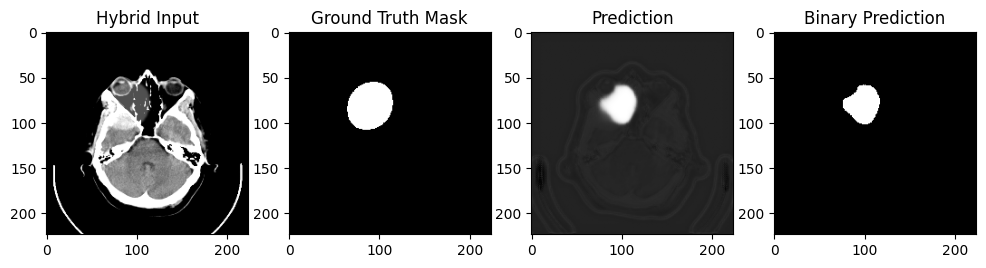

In [9]:
import os
MODEL_PATH = os.path.join(os.path.abspath('..'), 'models', 'best_unet_enhanced.pth')
try:
    img, mask = next(iter(dataloader))
    img = img.to(DEVICE)
    with torch.no_grad():
        pred = model(img)
        pred = torch.sigmoid(pred)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    # Un-normalize for display
    disp_img = img[0].cpu().permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    plt.imshow(np.clip(disp_img, 0, 1))
    plt.title('Hybrid Input')

    plt.subplot(1, 4, 2)
    plt.imshow(mask[0].cpu().squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred[0].cpu().squeeze(), cmap='gray')
    plt.title('Prediction')
    
    plt.subplot(1, 4, 4)
    plt.imshow(pred[0].cpu().squeeze() > 0.5, cmap='gray')
    plt.title('Binary Prediction')
    
    plt.show()
except Exception as e:
    print(f"Visualization error: {e}")